<a href="https://colab.research.google.com/github/achalgarg14/session_4/blob/main/Session_4_Assignment_Code_4_less_than_8k.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Attempt 4:
##Target:

* Lower number of parameters (Meet our second target of <=8000 Parameters)
* Accuracy 94% consistent in last few layers

##Results:

* Total Parameters: 7,416
* Best Training Accuracy: 99.22%
* Best Test Accuracy: 99.48%

##Analysis:

* Model was able to achieve it's target of 99.40% accuracy at 7th epoch and remained more than 99.40% after that aprt from 9th epoch.
* Model Architecture is the same as the previous one but with one less convolution layer.
* It trained well and has higher test accuracy than training accuracy across epochs.

# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std 
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? False


# The model
Let's start with the model we first saw

In [5]:
import torch.nn.functional as F
dropout_value = 0.05
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = 26  RF = 3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 24  RF = 5

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24  RF = 5
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12  RF = 6

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 10  RF = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 8   RF = 14
        
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 8   RF = 18
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=8)
        ) # output_size = 1  RF = 32

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 1  RF = 32


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.gap(x)        
        x = self.convblock7(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [6]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9            [-1, 8, 24, 24]             128
        MaxPool2d-10            [-1, 8, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,152
             ReLU-12           [-1, 16, 10, 10]               0


# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [7]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [9]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

EPOCH: 1


Loss=0.08841723203659058 Batch_id=937 Accuracy=93.68: 100%|██████████| 938/938 [01:12<00:00, 12.93it/s]



Test set: Average loss: 0.0876, Accuracy: 9740/10000 (97.40%)

EPOCH: 2


Loss=0.08565649390220642 Batch_id=937 Accuracy=97.68: 100%|██████████| 938/938 [01:14<00:00, 12.57it/s]



Test set: Average loss: 0.0381, Accuracy: 9878/10000 (98.78%)

EPOCH: 3


Loss=0.07878271490335464 Batch_id=937 Accuracy=98.19: 100%|██████████| 938/938 [01:19<00:00, 11.84it/s]



Test set: Average loss: 0.0358, Accuracy: 9889/10000 (98.89%)

EPOCH: 4


Loss=0.19016949832439423 Batch_id=937 Accuracy=98.36: 100%|██████████| 938/938 [01:16<00:00, 12.31it/s]



Test set: Average loss: 0.0318, Accuracy: 9894/10000 (98.94%)

EPOCH: 5


Loss=0.0011694326531141996 Batch_id=937 Accuracy=98.47: 100%|██████████| 938/938 [01:14<00:00, 12.59it/s]



Test set: Average loss: 0.0283, Accuracy: 9908/10000 (99.08%)

EPOCH: 6


Loss=0.01087805163115263 Batch_id=937 Accuracy=98.58: 100%|██████████| 938/938 [01:21<00:00, 11.44it/s]



Test set: Average loss: 0.0329, Accuracy: 9886/10000 (98.86%)

EPOCH: 7


Loss=0.32479891180992126 Batch_id=937 Accuracy=98.92: 100%|██████████| 938/938 [01:17<00:00, 12.07it/s]



Test set: Average loss: 0.0188, Accuracy: 9947/10000 (99.47%)

EPOCH: 8


Loss=0.015749912708997726 Batch_id=937 Accuracy=99.08: 100%|██████████| 938/938 [01:14<00:00, 12.61it/s]



Test set: Average loss: 0.0185, Accuracy: 9943/10000 (99.43%)

EPOCH: 9


Loss=0.0016925112577155232 Batch_id=937 Accuracy=99.09: 100%|██████████| 938/938 [01:16<00:00, 12.29it/s]



Test set: Average loss: 0.0191, Accuracy: 9939/10000 (99.39%)

EPOCH: 10


Loss=0.001324022770859301 Batch_id=937 Accuracy=99.16: 100%|██████████| 938/938 [01:14<00:00, 12.65it/s]



Test set: Average loss: 0.0179, Accuracy: 9944/10000 (99.44%)

EPOCH: 11


Loss=0.08533356338739395 Batch_id=937 Accuracy=99.14: 100%|██████████| 938/938 [01:13<00:00, 12.71it/s]



Test set: Average loss: 0.0179, Accuracy: 9946/10000 (99.46%)

EPOCH: 12


Loss=0.01163174957036972 Batch_id=937 Accuracy=99.12: 100%|██████████| 938/938 [01:13<00:00, 12.84it/s]



Test set: Average loss: 0.0174, Accuracy: 9945/10000 (99.45%)

EPOCH: 13


Loss=0.0029536751098930836 Batch_id=937 Accuracy=99.10: 100%|██████████| 938/938 [01:15<00:00, 12.44it/s]



Test set: Average loss: 0.0170, Accuracy: 9948/10000 (99.48%)

EPOCH: 14


Loss=0.10849199444055557 Batch_id=937 Accuracy=99.18: 100%|██████████| 938/938 [01:14<00:00, 12.64it/s]



Test set: Average loss: 0.0172, Accuracy: 9944/10000 (99.44%)

EPOCH: 15


Loss=0.0012979733292013407 Batch_id=937 Accuracy=99.22: 100%|██████████| 938/938 [01:14<00:00, 12.62it/s]



Test set: Average loss: 0.0168, Accuracy: 9948/10000 (99.48%)



# Plotting Accuracy and Loss Graphs

In [11]:
train_losses1 = [t.cpu().item() for t in train_losses]

Text(0.5, 1.0, 'Test Accuracy')

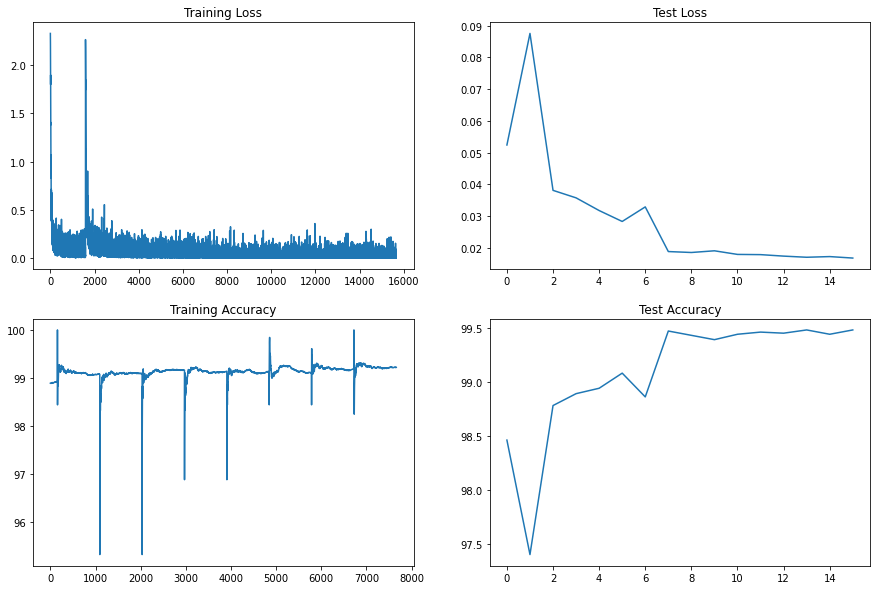

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses1)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[8000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")